It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/mehrerm/intro_deep_learning/blob/main/class/RNN/IMBD_RNN.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/mehrerm/intro_deep_learning/blob/main/class/RNN/IMBD_RNN.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

# Classification Example
 Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def show_loss_accuracy_evolution(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

## The Dataset: The IMDB dataset
We’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews. The  parameter `num_words` controls how many words different we want to use.

In [4]:
from tensorflow.keras.datasets import imdb
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
print(train_data[0])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


For transforming an id-sequence to a phrase use get_words

In [6]:
def get_words(sentence, int2word):
    return ' '.join([int2word.get(i, '<UNK>') for i in sentence])


get_words(train_data[0], int2word)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# MLP model

## Data Preprocessing

You need to convert your raw text to an appropriate input to a sequential model

In [7]:
def vectorize_text_sentence(text, word2int):
    tokens = text.split(' ')
    tokens_id = [word2int.get(tk,2) for tk in tokens]
    return tokens_id

text = get_words(train_data[0], int2word)
print(text)
print(vectorize_text_sentence(text, word2int))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

We are going to use a bag of words model. BoW is a simplifying representation used in natural language processing. In this model, a text (such as a sentence or a document) is represented as the Each key is the word, and each value is the frequency of occurrences of that word in the given text document.

- **Input document**: `"John likes to watch movies Mary likes movies too"`
- **BoW**: `{'John': 0.11, 'likes': 0.22, 'to': 0.11, 'watch': 0.11, 'movies': 0.22, 'Mary': 0.11, 'too': 0.11}`


In [8]:
from collections import Counter


def get_bag_of_words(sequence, norm=True):
    word_count = Counter(sequence)
    if norm:
        total = sum(word_count.values())
        word_freq = {w: n / total for w, n in word_count.items()}
        return word_freq
    else:
        return dict(word_count.items())


text_example = "John likes to watch movies Mary likes movies too"
print('text_example', text_example)
text_sequence = text_example.split()
print('text splitted', text_sequence)
bag_of_words = get_bag_of_words(text_sequence)
print('bag_of_words', bag_of_words)
print('bag_of_words norm=False', get_bag_of_words(text_sequence, norm=False))
print(
    'bag_of_words with indexes', {
        word2int[w.lower()]: p
        for w, p in get_bag_of_words(text_sequence, norm=False).items()
    })

text_example John likes to watch movies Mary likes movies too
text splitted ['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too']
bag_of_words {'John': 0.1111111111111111, 'likes': 0.2222222222222222, 'to': 0.1111111111111111, 'watch': 0.1111111111111111, 'movies': 0.2222222222222222, 'Mary': 0.1111111111111111, 'too': 0.1111111111111111}
bag_of_words norm=False {'John': 1, 'likes': 2, 'to': 1, 'watch': 1, 'movies': 2, 'Mary': 1, 'too': 1}
bag_of_words with indexes {308: 1, 1232: 2, 8: 1, 106: 1, 102: 2, 1083: 1, 99: 1}


After that, we convert every BoW to a vector of `dim=num_words` with `vectorize_sequences`

In [9]:
def vectorize_sequence(sequence, num_words, norm=True):
    vec = np.zeros(num_words)
    bow = get_bag_of_words(sequence, norm)
    for w, freq in bow.items():
        if w < num_words:
            vec[w] = freq
    return vec


def vectorize_sequences(sequences, num_words=num_words, norm=True):
    """Creates an all-zero matrix of shape (len(sequences), num_words)"""
    results = np.zeros((len(sequences), num_words))
    for i, sequence in enumerate(sequences):
        results[i, :] = vectorize_sequence(sequence, num_words, norm)
    return results


x_train = vectorize_sequences(train_data, num_words=num_words)
x_test = vectorize_sequences(test_data, num_words=num_words)
y_train =np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
x_train.shape, y_train.shape

((25000, 10003), (25000,))

## Define and train a model
Define, compile and fit your sequential model

In [10]:
model = ...
history = model.fit(x_train, y_train, validation_split=0.2, ...)

SyntaxError: positional argument follows keyword argument (ipython-input-724713935.py, line 2)

In [ ]:
show_loss_accuracy_evolution(history)

### Evaluate the model
You need to obtain a Test Accuracy > 0.85. Try to get more than 0.9!

In [ ]:
results = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

x_pred = vectorize_sequences(sequences, num_words=num_words)
np.round(model.predict(x_pred), 4)

# RNN model

Lets use a recurrent neural network and compare results


### Simple RNN model

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````
For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).





In sequence classification we are going to use the **many-to-one** architecture with default parameter `return_sequences=False`.

The shape of the output  for this architecture  is `(batch_size, units)`.
where `units` corresponds to the `units` argument passed to the layer's constructor.

Lets see one some examples for understanding the input/output dimensions:

In [11]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 4])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 2)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

input dim (batch, timesteps, feature):  (32, 10, 4)
return_state=False output shape:  (32, 2)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [12]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [13]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,242 (309.54 KB)

 Trainable params: 79,242 (309.54 KB)

 Non-trainable params: 0 (0.00 B)

### Loading Data

In [14]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
'''size = 15000
(train_data, train_labels), (test_data, test_labels) = (
    (train_data[:size], train_labels[:size]), (test_data[:size], test_labels[:size]))
'''
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3

print(train_data.shape, test_data.shape)

(25000,) (25000,)


#### Data Preprocessing

For data preprocessing we first use [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences):
```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```
- **padding**:	'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.
- **truncating**:	String, 'pre' or 'post' (optional, defaults to 'pre'): remove values from sequences larger than maxlen, either at the beginning or at the end of the sequences.


Our RNN will take sequences of constant length. In our case this length is the `maxlen`

In [15]:
from tensorflow.keras.preprocessing import sequence
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len)
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[0 0 1 2 3]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[5 6 7 8 9]]


In [16]:
input_seq = [1, 2, 3]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, padding='post')
print('input sequence with padding: ', pad_seq)

input_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9]
max_len = 5
print('input sequence: ', input_seq)
pad_seq = sequence.pad_sequences([input_seq], maxlen=max_len, truncating='post')
print('input sequence with padding: ', pad_seq)


input sequence:  [1, 2, 3]
input sequence with padding:  [[1 2 3 0 0]]
input sequence:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
input sequence with padding:  [[1 2 3 4 5]]


In [17]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


### Create the RNN model

For the input of the first rnn layer we need a tensor of `(timesteps, features)` or `(batchsize, timesteps, features)`. We have a matrix of sentences of `(train_size, max_len)`. Every sentence is a  `max_len`, we need to convert it to a sentence of one-hot vectors of dim `(max_len, num_words)`.
For get the one-hot encoding of every sequence we are going to use:

```python
layers.Embedding(input_dim=num_words, output_dim=num_words,
  input_length=max_len, embeddings_initializer='identity', trainable=False)
```

This layer converts the input tensor `(batch_size, max_len)` to one-hot encoded sequences `(batch_size, max_len, num_words)`





In [18]:
seq = np.array([[[0, 1, 2, 2, 0]]])
print(seq, seq.shape)
layers.Embedding(input_dim=3, output_dim=3,
                 input_length=5, embeddings_initializer='identity',
                 trainable=False)(seq)

[[[0 1 2 2 0]]] (1, 1, 5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<tf.Tensor: shape=(1, 1, 5, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]]], dtype=float32)>

### RNN model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))
## complete the model with recurrent layers
#model.add(...)
model.add(layers.SimpleRNN(16, return_sequences=False))
## add binary classification output
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
## set the loss and see the results
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)


Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 55s 609ms/step - accuracy: 0.5684 - loss: 0.6709 - val_accuracy: 0.7512 - val_loss: 0.5451
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 609ms/step - accuracy: 0.7875 - loss: 0.4971 - val_accuracy: 0.7992 - val_loss: 0.4815
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 604ms/step - accuracy: 0.8239 - loss: 0.4281 - val_accuracy: 0.8080 - val_loss: 0.4406
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 624ms/step - accuracy: 0.8464 - loss: 0.3784 - val_accuracy: 0.8088 - val_loss: 0.4271
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 52s 586ms/step - accuracy: 0.8594 - loss: 0.3527 - val_accuracy: 0.8080 - val_loss: 0.4209


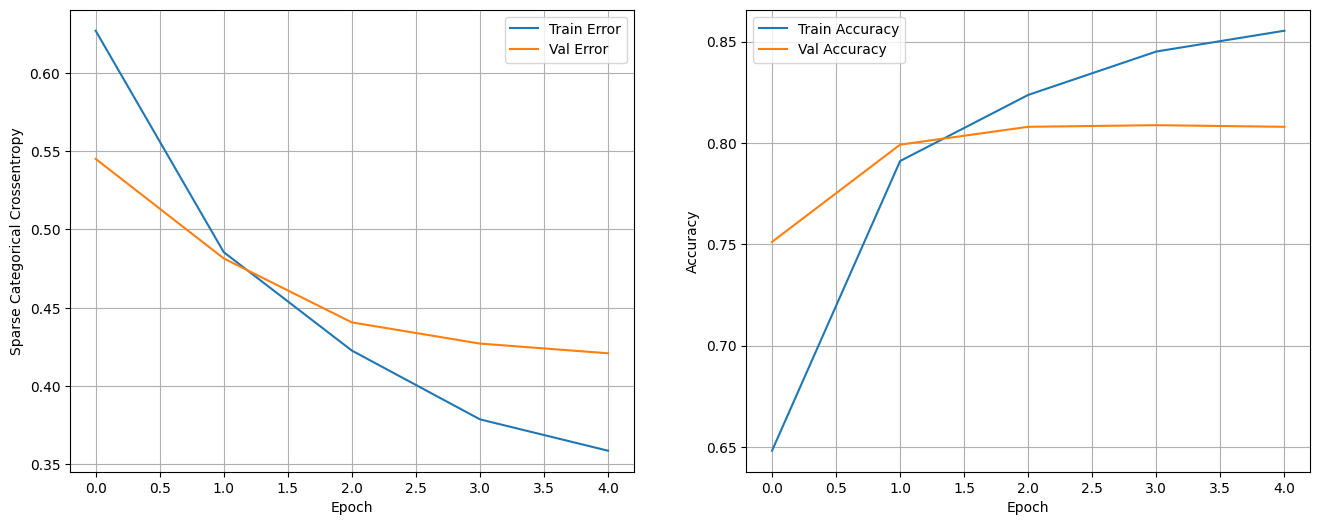

782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.7972 - loss: 0.4422
Test Loss: 0.44493556022644043
Test Accuracy: 0.7936400175094604


In [21]:
show_loss_accuracy_evolution(history)
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [22]:
def show_errors(x_test, model, labels, int2word, n_samples=10):
    preds = 1.0 * (model.predict(x_test).flatten() > 0.5)
    bad_pred_inds = np.where(preds != labels)[0]
    n_samples = min(len(bad_pred_inds), n_samples)
    samples_inds = np.random.choice(bad_pred_inds, n_samples)
    for ind in samples_inds:
        print('Predicted : {0}, real : {1}, lenght: {2}'.format(
            int(preds[ind]), labels[ind], len(test_data[ind])))
        print(get_words(test_data[ind], int2word))
        print()
    return

show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step
Predicted : 0, real : 1, lenght: 356
<START> if <UNK> <UNK> was <UNK> he may well have been joe however all in the family would have had a rather short run because the <UNK> would never have allowed it to run along the lines of this movie joe is a working class guy who is a <UNK> and a <UNK> and has a big mouth especially when he's drunk one night he meets a man in a bar bill who is having a <UNK> to <UNK> his <UNK> <UNK> after <UNK> killing his <UNK> <UNK> boyfriend and he lets that <UNK> to joe what happens is that <UNK> daughter was living with the <UNK> and she's <UNK> off to the hospital after an <UNK> and he goes by the apartment to <UNK> her things but doesn't expect that <UNK> actually run into the boyfriend who comes in fresh from a big drug deal in the struggle that <UNK> the boyfriend is killed <UNK> and bill doesn't want anyone really to know of course but he lets it <UNK> to joe and then when the <UNK> and tv <UNK> come out joe se

#### Making predictioins with new data

In [23]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


array([[0.0879],
       [0.9256],
       [0.9249],
       [0.9018],
       [0.1034],
       [0.0909]], dtype=float32)

In [24]:
1.0*(model.predict(x_pred) > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

### GRU model
Use `keras.layers.GRU`


In [32]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
##model.add(...)
model.add(layers.GRU(16, return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))


In [33]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    ##loss=...,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 69s 757ms/step - accuracy: 0.5161 - loss: 0.6922 - val_accuracy: 0.5792 - val_loss: 0.6842
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 68s 773ms/step - accuracy: 0.6577 - loss: 0.6211 - val_accuracy: 0.7716 - val_loss: 0.4872
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 754ms/step - accuracy: 0.8024 - loss: 0.4392 - val_accuracy: 0.8076 - val_loss: 0.4227
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 725ms/step - accuracy: 0.8377 - loss: 0.3790 - val_accuracy: 0.8076 - val_loss: 0.4175
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 725ms/step - accuracy: 0.8438 - loss: 0.3629 - val_accuracy: 0.8144 - val_loss: 0.4112


In [34]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8060 - loss: 0.4228
Test Loss: 0.42710161209106445
Test Accuracy: 0.8046000003814697


### LSTM model
Use `keras.layers.LSTM`


In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(...)

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: Ellipsis (of type <class 'ellipsis'>)

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss=...,
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Deep model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` or `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(...)

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss=...,
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

### Bidirectional model
Use `keras.layers.SimpleRNN`,  `keras.layers.GRU`,  `keras.layers.LSTM` with `keras.layers.Bidirectional`


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))

## complete the model with recurrent layers
model.add(...)

In [ ]:
## set the loss and see the results
model.compile(
    optimizer='adam',
    loss=...,
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

In [ ]:
results = model.evaluate(x_test_seq, test_labels, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

#### Making predictioins with new data

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad',
          'the movie is not bad I like it']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

In [ ]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)

###  Use a convolutional network instead of a RNN

```python
tf.keras.layers.Conv1D(
    filters, kernel_size
)
```

```python
tf.keras.layers.MaxPool1D(
    pool_size=2
)
```

```python
tf.keras.layers.Flatten()
```

In [ ]:
from tensorflow.keras.datasets import imdb
num_words = 2000
((train_data, train_labels), (test_data, test_labels)
 ) = imdb.load_data(num_words=num_words)

#  limit the data for class time
# Transform word_id to word and reverse
word2int = imdb.get_word_index()
word2int = {w: i+3 for w, i in word2int.items()}
word2int["<PAD>"] = 0
word2int["<START>"] = 1
word2int["<UNK>"] = 2
word2int["<UNUSED>"] = 3
int2word = {i: w for w, i in word2int.items()}
num_words = num_words+3


In [ ]:
max_len = 100
x_train_seq = sequence.pad_sequences(train_data, maxlen=max_len, truncating='post', padding='post')
x_test_seq = sequence.pad_sequences(test_data, maxlen=max_len, truncating='post', padding='post')

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(max_len,), name='input'))
## one-hot encoding
model.add(layers.Embedding(input_dim=num_words, output_dim=num_words,
                           input_length=max_len, embeddings_initializer='identity',
                           trainable=False))


model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
epochs = 5
history = model.fit(x_train_seq, train_labels,
                    validation_split=0.1, epochs=epochs,
                    batch_size=256)

In [ ]:
reviews = ['the film was really bad and i am very disappointed',
           'The film was very funny entertaining and good we had a great time . brilliant film',
           'this film was just brilliant',
           'the film is not good',
           'the film is not bad']
sequences = [vectorize_text_sentence(review.lower(), word2int)
             for review in reviews]

## Padding the sequences
x_pred  = sequence.pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')# ...

np.round(model.predict(x_pred), 4)

In [ ]:
show_errors(x_test_seq, model, test_labels, int2word, n_samples=10)